#### In this notebook, I will bring in the sample data and conduct KMeans clustering.  

Approach 1: Including both vectorized review text and other features(user-related features, business-related features.etc) <br>
1. Perform Tokenization <br>
2. Scale numeric features <br>
3. Hyperparameters tuning <br>
4. Run optimal KMeans model <br>

Approach 2: Only including vectorized review text
1. Perform Tokenization <br>
2. Scale numeric features <br>
3. Hyperparameters tuning <br>
4. Run optimal KMeans model <br>

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import data
df = joblib.load('sample_review.py') 
df.reset_index(inplace = True, drop = True)
# get the shape of data
df.shape

(3696, 10)

In [3]:
# Import packages for text preprocessing
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
from nltk.corpus import stopwords 

[nltk_data] Downloading package stopwords to /Users/ying/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# define a customized tokenizing function 
ENGLISH_STOP_WORDS = stopwords.words('english')
stemmer = nltk.stem.PorterStemmer()
def my_tokenizer(doc):
    doc = doc.lower()
    doc = "".join(char for char in doc if char in "abcdefghijklmnopqrstuvwxyz ")
    words = doc.split()
    words = list(word for word in words if word not in ENGLISH_STOP_WORDS)
    words = list(stemmer.stem(word) for word in words if len(word) >=3)
    return words

In [5]:
# Processing review text
bagofwords = CountVectorizer(tokenizer=my_tokenizer, max_features = 500) 
bagofwords.fit(df['text'])
text_transformed = bagofwords.transform(df['text'])

/Users/ying/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [6]:
# sanity check
text_df = pd.DataFrame(columns=bagofwords.get_feature_names_out(), data=text_transformed.toarray())
text_df.head()

,abl,absolut,actual,ad,add,addit,ago,almost,along,alreadi,...,wouldnt,wrap,wrong,ye,year,yelp,yet,your,yum,yummi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Append review text vectors to the sample review data
df = pd.concat([df, text_df], axis=1)

In [8]:
# sanity check
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,sample_yn,text,...,wouldnt,wrap,wrong,ye,year,yelp,yet,your,yum,yummi
0,fGYcFOHfQL4stYPdD3J47g,CgyCtH9CbLO7J_uO3cL7OA,PzhPMkaNYiKDTHoTG0r8rw,4.0,0,0,0,2016-09-18 22:43:18,1,After 3 weeks of working in the area I finally...,...,0,0,0,0,0,0,0,0,0,0
1,EwkeL8nm4vug3htgi0ZbsQ,_exJkgTPirjUjEUbQju2ow,PzhPMkaNYiKDTHoTG0r8rw,5.0,0,0,0,2017-04-19 12:34:20,1,Soup was fresh spicy and delicious! Wish it wa...,...,0,0,0,0,0,0,0,0,0,0
2,KRowK5RRz8IF2auM-8ROSw,zEuTnMbf5IEQ1TiEGWHVQg,PzhPMkaNYiKDTHoTG0r8rw,3.0,0,0,0,2018-09-03 02:20:28,1,A pho place that checks all the boxes but does...,...,0,0,0,0,0,0,0,0,0,0
3,66KUpAcnKRA3BB_BNSgjpw,X3APf4FSiOYg4BB6sdhJPw,PzhPMkaNYiKDTHoTG0r8rw,5.0,1,0,0,2018-07-07 22:45:43,1,Steamed buns for the adults. Beef & Broccoli f...,...,0,0,0,0,0,0,0,0,0,0
4,fFFHTE0tY1OFqV50Iiy92Q,CQW0mI3IXtOeVv5TNDuuhw,PzhPMkaNYiKDTHoTG0r8rw,5.0,0,0,0,2015-11-06 00:36:28,1,The spicy beef pho is wonderful. The broth is ...,...,0,0,0,0,0,0,0,0,0,0


### Add features related to user, business and review
1. User-relevant => review_count, elite_yn, yelp_time, avg_star, sum of useful/funny/cool, sum of compliments <br>
2. Business-relevant => review count, star  <br>

Note: These variables will be extracted from user data and business data using user_id and business_id of sample review data.

In [9]:
# Iort business data
df_business = pd.read_json('yelp_academic_dataset_business.json', lines=True)

In [10]:
# Add business related features to sample review data
df['rv_ct_business'] = 0
df['star_business'] = 0
for i in range(len(df)):
    bid = df['business_id'][i]
    dat = df_business[df_business['business_id'] == bid]
    df['rv_ct_business'][i] = dat['review_count']
    df['star_business'][i] = dat['stars']

/var/folders/nj/f9znvfvs4znf7d4g_hm9z7nm0000gn/T/ipykernel_57976/4138965038.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rv_ct_business'][i] = dat['review_count']
/var/folders/nj/f9znvfvs4znf7d4g_hm9z7nm0000gn/T/ipykernel_57976/4138965038.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['star_business'][i] = dat['stars']


In [11]:
# sanity check
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,sample_yn,text,...,wrong,ye,year,yelp,yet,your,yum,yummi,rv_ct_business,star_business
0,fGYcFOHfQL4stYPdD3J47g,CgyCtH9CbLO7J_uO3cL7OA,PzhPMkaNYiKDTHoTG0r8rw,4.0,0,0,0,2016-09-18 22:43:18,1,After 3 weeks of working in the area I finally...,...,0,0,0,0,0,0,0,0,178,4.5
1,EwkeL8nm4vug3htgi0ZbsQ,_exJkgTPirjUjEUbQju2ow,PzhPMkaNYiKDTHoTG0r8rw,5.0,0,0,0,2017-04-19 12:34:20,1,Soup was fresh spicy and delicious! Wish it wa...,...,0,0,0,0,0,0,0,0,178,4.5
2,KRowK5RRz8IF2auM-8ROSw,zEuTnMbf5IEQ1TiEGWHVQg,PzhPMkaNYiKDTHoTG0r8rw,3.0,0,0,0,2018-09-03 02:20:28,1,A pho place that checks all the boxes but does...,...,0,0,0,0,0,0,0,0,178,4.5
3,66KUpAcnKRA3BB_BNSgjpw,X3APf4FSiOYg4BB6sdhJPw,PzhPMkaNYiKDTHoTG0r8rw,5.0,1,0,0,2018-07-07 22:45:43,1,Steamed buns for the adults. Beef & Broccoli f...,...,0,0,0,0,0,0,0,0,178,4.5
4,fFFHTE0tY1OFqV50Iiy92Q,CQW0mI3IXtOeVv5TNDuuhw,PzhPMkaNYiKDTHoTG0r8rw,5.0,0,0,0,2015-11-06 00:36:28,1,The spicy beef pho is wonderful. The broth is ...,...,0,0,0,0,0,0,0,0,178,4.5


In [12]:
# Import user data
df_user = joblib.load('df_user_update.py') 

In [13]:
# Get column names
df_user.columns

Index(['u_id', 'name', 'review_count', 'yelp_since', 'useful', 'funny', 'cool',
       'elite', 'fan', 'avg_star', 'c_hot', 'c_more', 'c_profile', 'c_cute',
       'c_list', 'c_note', 'c_plain', 'c_cool', 'c_funny', 'c_writer',
       'c_photos', 'label', 'yelp_time', 'elite_ct', 'elite_yn'],
      dtype='object')

In [14]:
# Add business related features to sample review data
df['rv_ct_user'] = 0
df['star_user'] = 0
df['elite_ct'] = 0
df['yelp_time'] = 0
df['feedback1'] = 0
df['feedback2'] = 0

for i in range(len(df)):
    # print (i)
    bid = df['user_id'][i]
    dat = df_user[df_user['u_id'] == bid]
    df['rv_ct_user'][i] = dat['review_count']
    df['star_user'][i] = dat['avg_star']
    df['elite_ct'][i] = dat['elite_ct']
    df['yelp_time'][i] = dat['yelp_time']
    df['feedback1'][i] = dat['useful'] + dat['funny'] + dat['cool']
    df['feedback2'][i] = dat['c_hot'] + dat['c_more'] + dat['c_profile'] + dat['c_cute'] + dat['c_list'] + dat['c_note']+ dat['c_plain'] + dat['c_cool'] + dat['c_funny'] + dat['c_writer'] + dat['c_photos'] 
   

/var/folders/nj/f9znvfvs4znf7d4g_hm9z7nm0000gn/T/ipykernel_57976/4067789506.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rv_ct_user'][i] = dat['review_count']
/var/folders/nj/f9znvfvs4znf7d4g_hm9z7nm0000gn/T/ipykernel_57976/4067789506.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['star_user'][i] = dat['avg_star']
/var/folders/nj/f9znvfvs4znf7d4g_hm9z7nm0000gn/T/ipykernel_57976/4067789506.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [15]:
# sanity check
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,sample_yn,text,...,yum,yummi,rv_ct_business,star_business,rv_ct_user,star_user,elite_ct,yelp_time,feedback1,feedback2
0,fGYcFOHfQL4stYPdD3J47g,CgyCtH9CbLO7J_uO3cL7OA,PzhPMkaNYiKDTHoTG0r8rw,4.0,0,0,0,2016-09-18 22:43:18,1,After 3 weeks of working in the area I finally...,...,0,0,178,4.5,37,3.54,0,7.495986,65,7
1,EwkeL8nm4vug3htgi0ZbsQ,_exJkgTPirjUjEUbQju2ow,PzhPMkaNYiKDTHoTG0r8rw,5.0,0,0,0,2017-04-19 12:34:20,1,Soup was fresh spicy and delicious! Wish it wa...,...,0,0,178,4.5,7,4.86,0,7.540627,1,0
2,KRowK5RRz8IF2auM-8ROSw,zEuTnMbf5IEQ1TiEGWHVQg,PzhPMkaNYiKDTHoTG0r8rw,3.0,0,0,0,2018-09-03 02:20:28,1,A pho place that checks all the boxes but does...,...,0,0,178,4.5,28,3.37,0,8.422484,21,1
3,66KUpAcnKRA3BB_BNSgjpw,X3APf4FSiOYg4BB6sdhJPw,PzhPMkaNYiKDTHoTG0r8rw,5.0,1,0,0,2018-07-07 22:45:43,1,Steamed buns for the adults. Beef & Broccoli f...,...,0,0,178,4.5,103,4.46,0,4.764377,15,0
4,fFFHTE0tY1OFqV50Iiy92Q,CQW0mI3IXtOeVv5TNDuuhw,PzhPMkaNYiKDTHoTG0r8rw,5.0,0,0,0,2015-11-06 00:36:28,1,The spicy beef pho is wonderful. The broth is ...,...,0,0,178,4.5,7,5.00,0,8.594365,0,0


In [17]:
# Drop variables that will not be included in the clustering model
df_final = df.drop(['review_id', 'user_id', 'business_id', 'date', 'sample_yn', 'text' ], axis = 1)
# sanity check
df_final.head()

,stars,useful,funny,cool,abl,absolut,actual,ad,add,addit,...,yum,yummi,rv_ct_business,star_business,rv_ct_user,star_user,elite_ct,yelp_time,feedback1,feedback2
0,4.0,0,0,0,0,0,0,0,0,0,...,0,0,178,4.5,37,3.54,0,7.495986,65,7
1,5.0,0,0,0,0,0,0,0,0,0,...,0,0,178,4.5,7,4.86,0,7.540627,1,0
2,3.0,0,0,0,0,0,0,0,0,0,...,0,0,178,4.5,28,3.37,0,8.422484,21,1
3,5.0,1,0,0,0,0,0,0,0,0,...,0,0,178,4.5,103,4.46,0,4.764377,15,0
4,5.0,0,0,0,0,0,0,0,0,0,...,0,0,178,4.5,7,5.00,0,8.594365,0,0


### Scaling

In [18]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df_final_ss = ss.fit_transform(df_final)

### Hyperparameter tuning 

In [20]:
# Running KMeans clustering with K ranging from 2 to 30
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_range = np.arange(2, 30)
inertia_list = []
silhouette_scores = []
for k in k_range:
    kmeans_mod = KMeans(n_clusters = k, n_init = 10)
    kmeans_mod.fit(df_final_ss)
    inertia_list.append(kmeans_mod.inertia_)
    cluster_labels = kmeans_mod.predict(df_final_ss)
    silhouette = silhouette_score(df_final_ss, cluster_labels)
    silhouette_scores.append(silhouette)

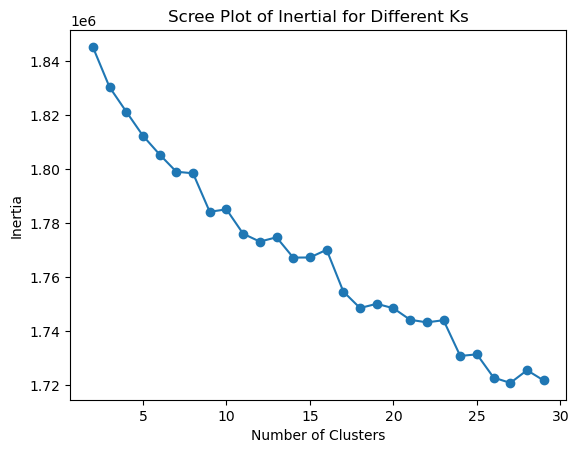

In [21]:
# Ploting intertia of different Ks
plt.figure()
plt.plot(k_range, inertia_list, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Scree Plot of Inertial for Different Ks')
plt.show()

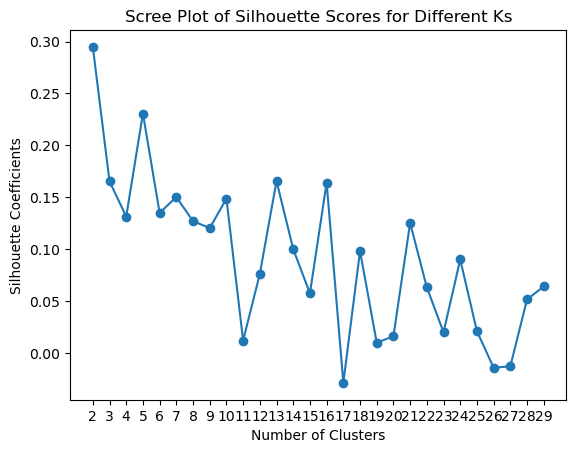

In [22]:
# Ploting Silhouette scores of different Ks
plt.figure()
plt.plot(k_range, silhouette_scores, marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficients')
plt.title('Scree Plot of Silhouette Scores for Different Ks')
plt.xticks(k_range)
plt.show();

#### The inertial scree plot indicate a very small 'elbow' at K = 7 and the scree plot of Silhouette score suggest K of 2 or 5 with the highest and the second highest Silhouette score. 

### Approach 1: clustering with all features

In [23]:
# Run KMeans clustering with k = 2
kmeans = KMeans(n_clusters=2, n_init = 10) 
kmeans.fit(df_final_ss)
cluster_labels = kmeans.predict(df_final_ss)
df_final['class'] = cluster_labels
df_final.head()

,stars,useful,funny,cool,abl,absolut,actual,ad,add,addit,...,yummi,rv_ct_business,star_business,rv_ct_user,star_user,elite_ct,yelp_time,feedback1,feedback2,class
0,4.0,0,0,0,0,0,0,0,0,0,...,0,178,4.5,37,3.54,0,7.495986,65,7,1
1,5.0,0,0,0,0,0,0,0,0,0,...,0,178,4.5,7,4.86,0,7.540627,1,0,1
2,3.0,0,0,0,0,0,0,0,0,0,...,0,178,4.5,28,3.37,0,8.422484,21,1,1
3,5.0,1,0,0,0,0,0,0,0,0,...,0,178,4.5,103,4.46,0,4.764377,15,0,1
4,5.0,0,0,0,0,0,0,0,0,0,...,0,178,4.5,7,5.00,0,8.594365,0,0,1


In [24]:
# Check the distribution of class
df_final['class'].value_counts()

1    2974
0     722
Name: class, dtype: int64

In [28]:
temp = pd.DataFrame(df_final_ss)
temp['class'] = df_final['class']
temp.columns = df_final.columns

In [29]:
temp.head()

,stars,useful,funny,cool,abl,absolut,actual,ad,add,addit,...,yummi,rv_ct_business,star_business,rv_ct_user,star_user,elite_ct,yelp_time,feedback1,feedback2,class
0,0.120723,-0.350793,-0.174431,-0.213799,-0.137685,-0.18451,-0.203292,-0.157217,-0.19107,-0.134461,...,-0.16585,-0.52238,1.6217,-0.332382,-0.344509,-0.542269,-0.428220,-0.095959,-0.041093,1
1,0.909048,-0.350793,-0.174431,-0.213799,-0.137685,-0.18451,-0.203292,-0.157217,-0.19107,-0.134461,...,-0.16585,-0.52238,1.6217,-0.426928,1.495771,-0.542269,-0.413085,-0.102779,-0.042373,1
2,-0.667602,-0.350793,-0.174431,-0.213799,-0.137685,-0.18451,-0.203292,-0.157217,-0.19107,-0.134461,...,-0.16585,-0.52238,1.6217,-0.360746,-0.581515,-0.542269,-0.114088,-0.100647,-0.042190,1
3,0.909048,-0.003291,-0.174431,-0.213799,-0.137685,-0.18451,-0.203292,-0.157217,-0.19107,-0.134461,...,-0.16585,-0.52238,1.6217,-0.124381,0.938110,-0.542269,-1.354383,-0.101287,-0.042373,1
4,0.909048,-0.350793,-0.174431,-0.213799,-0.137685,-0.18451,-0.203292,-0.157217,-0.19107,-0.134461,...,-0.16585,-0.52238,1.6217,-0.426928,1.690952,-0.542269,-0.055811,-0.102885,-0.042373,1


<Axes: xlabel='class'>

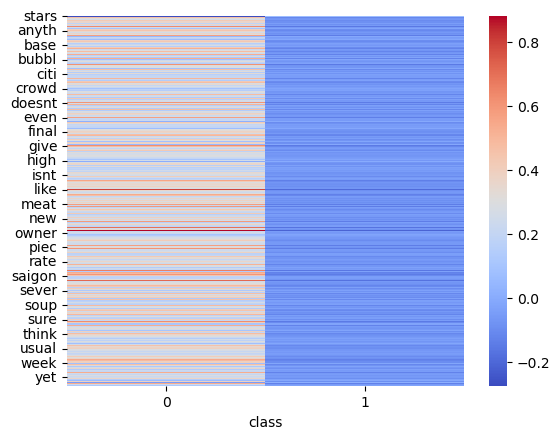

In [30]:
sns.heatmap(temp.groupby('class').mean().T, cmap = 'coolwarm')

<Axes: xlabel='class'>

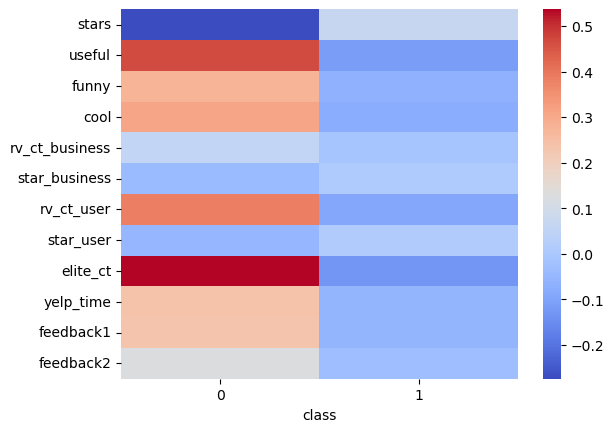

In [31]:
sns.heatmap(temp[['stars', 'useful', 'funny', 'cool', 'rv_ct_business', 'star_business', 'rv_ct_user', 'star_user',
       'elite_ct', 'yelp_time', 'feedback1', 'feedback2', 'class']].groupby('class').mean().T, cmap = 'coolwarm')

#### These 2 heatmaps suggest that the clustering is very likely between:
Cluster 1: Longer, more thorough reviews from more active yelpers that receive more positive feedback from other yelpers. <br>
Cluster 2: Shorter, more brief reviews from less active yelpers that receive less feedback from other yelpers.

### Approach 2 : clustering only with review text

In [32]:
k_range = np.arange(2, 30)
inertia_list2 = []
silhouette_scores2 = []
for k in k_range:
    kmeans_mod = KMeans(n_clusters = k, n_init = 10)
    kmeans_mod.fit(text_df)
    inertia_list2.append(kmeans_mod.inertia_)
    
    cluster_labels = kmeans_mod.predict(text_df)
    silhouette = silhouette_score(text_df, cluster_labels)
    silhouette_scores2.append(silhouette)

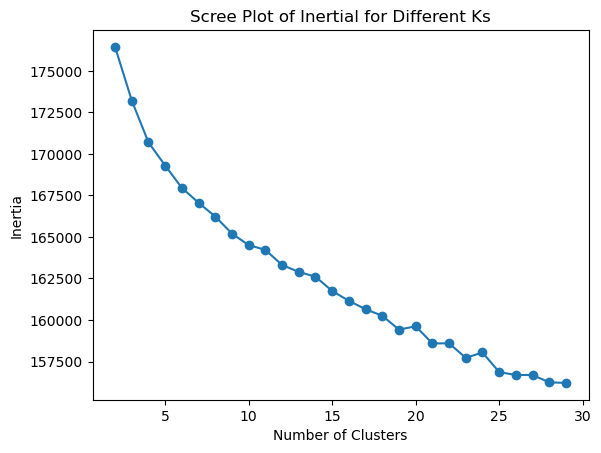

In [33]:
# Ploting intertia of different Ks
plt.figure()
plt.plot(k_range, inertia_list2, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Scree Plot of Inertial for Different Ks')
plt.show()

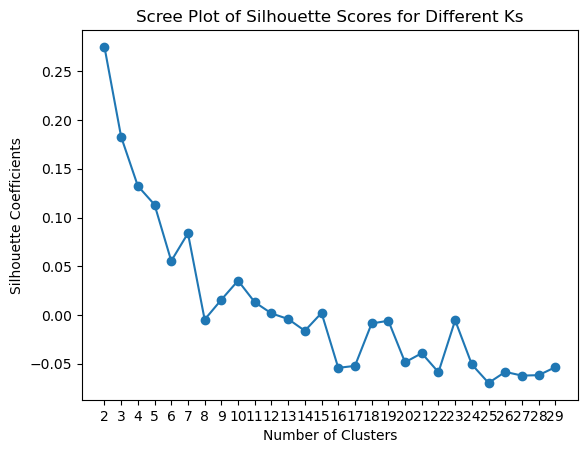

In [34]:
# Ploting Silhouette scores of different Ks
plt.figure()
plt.plot(k_range, silhouette_scores2, marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficients')
plt.title('Scree Plot of Silhouette Scores for Different Ks')
plt.xticks(k_range)
plt.show();

#### From previous trial, we know 2 clusters may not be sufficient. There is a local maximum of Silhouette score at K= 6. So for second approach. Hence, KMeans clustering is conducted with k = 6.

In [35]:
kmeans = KMeans(n_clusters=6, n_init = 10) 
kmeans.fit(text_df)
cluster_labels2 = kmeans.predict(text_df)
text_df['class'] = cluster_labels2
# sanity check
text_df.head()

,abl,absolut,actual,ad,add,addit,ago,almost,along,alreadi,...,wrap,wrong,ye,year,yelp,yet,your,yum,yummi,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [36]:
# Check the distribution of the class
text_df['class'].value_counts()

5    2073
4     615
1     598
2     232
3     107
0      71
Name: class, dtype: int64

In [37]:
temp['class2'] = text_df['class']
temp.head()

,stars,useful,funny,cool,abl,absolut,actual,ad,add,addit,...,rv_ct_business,star_business,rv_ct_user,star_user,elite_ct,yelp_time,feedback1,feedback2,class,class2
0,0.120723,-0.350793,-0.174431,-0.213799,-0.137685,-0.18451,-0.203292,-0.157217,-0.19107,-0.134461,...,-0.52238,1.6217,-0.332382,-0.344509,-0.542269,-0.428220,-0.095959,-0.041093,1,5
1,0.909048,-0.350793,-0.174431,-0.213799,-0.137685,-0.18451,-0.203292,-0.157217,-0.19107,-0.134461,...,-0.52238,1.6217,-0.426928,1.495771,-0.542269,-0.413085,-0.102779,-0.042373,1,5
2,-0.667602,-0.350793,-0.174431,-0.213799,-0.137685,-0.18451,-0.203292,-0.157217,-0.19107,-0.134461,...,-0.52238,1.6217,-0.360746,-0.581515,-0.542269,-0.114088,-0.100647,-0.042190,1,1
3,0.909048,-0.003291,-0.174431,-0.213799,-0.137685,-0.18451,-0.203292,-0.157217,-0.19107,-0.134461,...,-0.52238,1.6217,-0.124381,0.938110,-0.542269,-1.354383,-0.101287,-0.042373,1,5
4,0.909048,-0.350793,-0.174431,-0.213799,-0.137685,-0.18451,-0.203292,-0.157217,-0.19107,-0.134461,...,-0.52238,1.6217,-0.426928,1.690952,-0.542269,-0.055811,-0.102885,-0.042373,1,5


<Axes: xlabel='class2'>

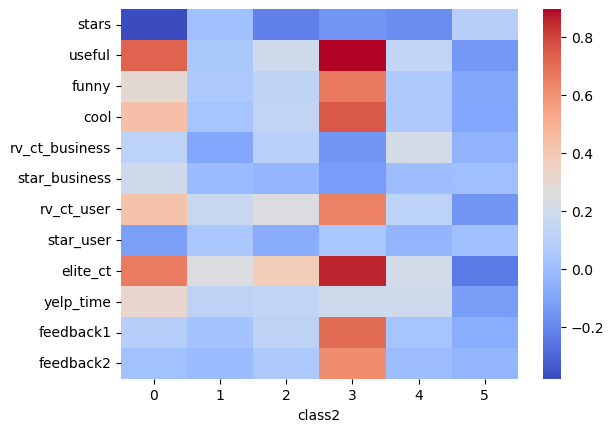

In [38]:
sns.heatmap(temp[['stars', 'useful', 'funny', 'cool', 'rv_ct_business', 'star_business', 'rv_ct_user', 'star_user',
       'elite_ct', 'yelp_time', 'feedback1', 'feedback2', 'class2']].groupby('class2').mean().T, cmap = 'coolwarm')

In [39]:
df['class'] = temp['class2']

In [40]:
df[df['class'] == 3]['text'].values

array(["In a city where the best Vietnamese food can often be found outside of a restaurant, pho cam ly strives to change the norm.  Right away one might think that this is just another pho restaurant that caters to Americans because it is nestled on the beautiful Magazine street in uptown. I sure did. But I was pleasantly surprised to be proven wrong. First, the menu isn't by any means limited. Along with offering a wide variety of pho and com dishes, I was delighted to see bun bo hue on the menu (though I admit I haven't tried it yet). I've been disappointed too many times to see the dish not included on other menus, so that was a plus. Second,  the dish I ordered, pho chin gan, was very delicious. Not only were they generous with their meat portion, the soup wasn't too oily. Too often I've left pho restaurants too full of oil that I end up being a couch potato the rest of the day. However, I did have a bite of my girlfriend's pho ga and the chicken was disappointing. It was quite dr

In [41]:
df[df['class'] == 1]['text'].values

array(["A pho place that checks all the boxes but doesnt have the best of anything.  We went to Lily's the day before, so I guess this review is a compare and contrast.  Decor is simple, white wall with 7 frames of challenge winners and 2 laggy TVs.  The service is fine, not as personal, but nothing really to complain.  The food was the biggest difference between the places.  The pho was plain, no complexity, almost like it came from a dry seasoning pack.  They also recommended the chicken vermicelli as one of their best -- it wasn't.  First off, they call it vermicelli but they used pho noodle instead?  What!!?? It was thick, heavy, and full the stomach quick --- everything a vermicelli not suppose to be.  Anyway, we left unsatisfied.",
       "Can't believe I'd never been here before- I live right around the corner! Pho Cam Ly is everything I want my pho place to be- unassuming and delicious. This is the first pho place I've found on this side of the river that serves tendon in their

In [43]:
df[df['class'] == 5]['text'].values[:10]

array(["After 3 weeks of working in the area I finally found a place off of Magazine that is not overrated. Friendly staff! Y'all know I love Phò so it's pretty damn good!",
       'Soup was fresh spicy and delicious! Wish it was closer to our house because I would eat there all the time!',
       'Steamed buns for the adults. Beef & Broccoli for the kids. Great service. Good for kids. Food holds up if you opt to take out. Our favorite to go spot.',
       "The spicy beef pho is wonderful. The broth is really good, the best I've had in a while. Service is great too!",
       'Love this place! Quick, delicious and service is great. Pho, bahn mis and spring rolls are all perfect! Never miss an opportunity to eat here.',
       'Great pho and the service was outstanding.  Easy parking too.  Staff enjoys serving and makes you feel welcome.  Food was very good.',
       "We were tourists that escaped deep-fried-shtuff (DPS) of French Quarter in search of something plain and comforting. We f

In [44]:
df[df['class'] == 2]['text'].values[:10]

array(["Gave this place a try after being disappointed with another Vietnamese restaurant in St. Albert.\n\nWe were pleasantly surprised to find it busy on a weekday and the menu had a lot of variety including a kids option for Pho with meatballs, brisket, and no scallion and beverage for $5!  We opted for plain wonton soup for our toddler, but none the less impressive!\n\nMy husband had the adult version of the Pho with meatballs and brisket - the large was under $8.  I had the vermicelli bowl with steak, shrimp, and spring rolls which was $10.\n\nThe fish sauce was seasoned nicely and I appreciated the 3 options of hot sauce on our table in addition to hoisson sauce.\n\nI enjoyed everything except the shrimp... next time, I'll just order the steak and spring roll vermicelli for $2 less - $8 (a great price!).\n\nEverything tasted fresh and full of flavor.\n\nThe one thing I didn't like... I asked for a half cup of rice for my toddler to have with her bowl of wont ton soup... and we we